In [1]:
from analysis_utils import prepare_df, aggregate_by_fields
import json
import numpy as np
from datasets import load_dataset
from analysis_utils import *
%load_ext autoreload
%autoreload 2

In [2]:
def get_verdict_ids_from_batch(verdict_group_batch):
    with open(f"../results/verdict_groups/{verdict_group_batch}.json", "r") as f:
        data = json.load(f)

    verdict_ids = []
    for run in data["runs"]:
        verdict_ids.append(run['verdict_run_id'])

    return verdict_ids, data

Plot 1

In [3]:
verdict_group_batch = "82ifg57"
verdict_ids, _ = get_verdict_ids_from_batch(verdict_group_batch)

In [4]:
verdicts_df = prepare_df(specific_verdict_ids=verdict_ids)
verdicts_df = verdicts_df[(verdicts_df['is_correct_qa_judge'].notnull()) & (verdicts_df['is_correct_verdict'].notnull()) & (verdicts_df['is_correct_qa_debater'].notnull())]


/Users/joshlevy/projects/llm_judge_debate_NEW/analysis/analysis_utils.py:102: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(aligned_dfs, ignore_index=True)
/Users/joshlevy/projects/llm_judge_debate_NEW/analysis/analysis_utils.py:102: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(aligned_dfs, ignore_index=True)


In [5]:
aggregate_acc = aggregate_by_fields(verdicts_df, fields=['config_model_name_qa_judge'])
aggregate_acc = aggregate_acc.iloc[0:-1:4]


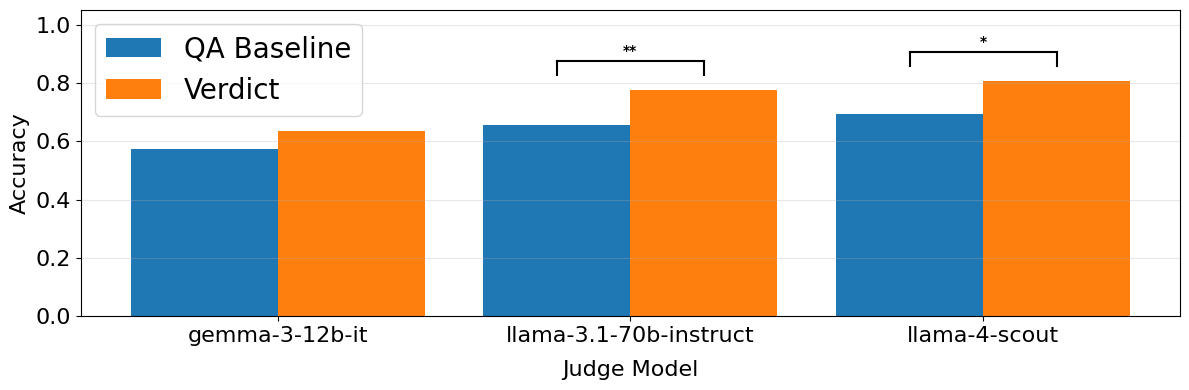

In [6]:
from plot_utils import *
aggregate_acc = aggregate_acc[aggregate_acc['name'] != 'x-ai/grok-4-fast']
plot_results_by_name(aggregate_acc, plot_gap_and_gain=False)
plt.show()

Plot 2

In [7]:
verdict_group_batch = "4r30ivy"
verdict_ids, data = get_verdict_ids_from_batch(verdict_group_batch)

In [8]:
verdict_ids

['1fj2i05',
 'juku5ze',
 'qglv702',
 '2w6ge2u',
 '6pimftp',
 't9icnd3',
 'b8gewd2',
 'krk0a9q',
 '7qy5yv0',
 'khnl8h5',
 '04b8m8o']

In [9]:
verdicts_df = prepare_df(specific_verdict_ids=verdict_ids)
verdicts_df = verdicts_df[(verdicts_df['is_correct_qa_judge'].notnull()) & (verdicts_df['is_correct_verdict'].notnull()) & (verdicts_df['is_correct_qa_debater'].notnull())]

/Users/joshlevy/projects/llm_judge_debate_NEW/analysis/analysis_utils.py:102: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(aligned_dfs, ignore_index=True)


In [10]:
aggregate_acc = aggregate_by_fields(verdicts_df, fields=['verdict_run_id_verdicts'])

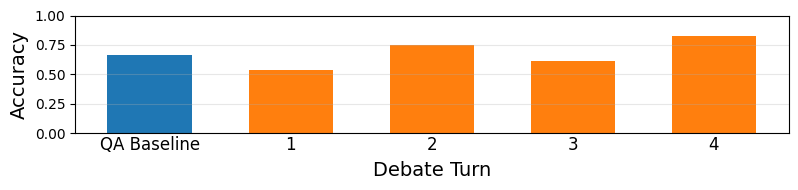

In [11]:
for run_idx in [0]:
    run_mapping = pd.DataFrame(data['runs'])
    merged = aggregate_acc.merge(run_mapping, left_on='name', right_on='verdict_run_id')
    plot_data = merged[merged['run_idx'] == run_idx].copy()
    
    if 'upto_turns' in plot_data.columns:
        upto_turns_list = sorted([x for x in plot_data['upto_turns'].dropna().unique()])
        upto_turns_list = upto_turns_list[:-6]
        upto_turns_list = [x for x in upto_turns_list if x != 0]
    else:
        upto_turns_list = [None]
    
    n_bars = 1 + len(upto_turns_list)
    x = np.arange(n_bars)
    width = 0.6
    
    fig, ax = plt.subplots(figsize=(8, 2))
    
    rows = plot_data
    judge_qa_value = rows['judge_qa_acc'].mean()
    judge_qa_n_correct = int(rows['judge_qa_n_correct'].sum())
    judge_qa_n_total = int(rows['n_judge_qa_not_null'].sum())
    
    bar_judge_qa = ax.bar(0, judge_qa_value, width, label='QA Baseline', alpha=1.0, color='C0')
    ax.text(0, -0.02, 'QA Baseline', ha='center', va='top', fontsize=12)
    
    for i, upto_turns in enumerate(upto_turns_list):
        if upto_turns is not None:
            turn_data = plot_data[plot_data['upto_turns'] == upto_turns].copy()
        else:
            turn_data = plot_data.copy()
        
        if len(turn_data) > 1:
            raise Exception('Check why rows greater than 1')
        
        verdict_value = turn_data.iloc[0]['verdict_acc']
        verdict_n_correct = int(turn_data.iloc[0]['verdict_n_correct'])
        verdict_n_total = int(turn_data.iloc[0]['n_verdict_not_null'])
        
        bar_idx = i + 1
        label = f"{upto_turns if upto_turns is not None else 'All'} Turns"
        bar = ax.bar(bar_idx, verdict_value, width, label=label, alpha=1.0, color='C1')
        
        turn_label = f"{upto_turns if upto_turns is not None else 'All'}"
        ax.text(bar_idx, -0.02, turn_label, ha='center', va='top', fontsize=12)
    
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_xlabel('Debate Turn', fontsize=14, labelpad=20)
    ax.set_xticks([])
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0, 1])
    # ax.legend(fontsize=12)
    
    plt.tight_layout()
    plt.show()

Plot 3

In [12]:
debate_run_id = 'suu380s'
df = prepare_df(['debates'])
df = df[df['run_id_debates'] == debate_run_id]
df.shape

/Users/joshlevy/projects/llm_judge_debate_NEW/analysis/analysis_utils.py:102: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(aligned_dfs, ignore_index=True)


(197, 49)

In [13]:
correct_debater_response_times = []
incorrect_debater_response_times = []
correct_reasoning_tokens = []
incorrect_reasoning_tokens = []
from collections import defaultdict
correct_by_turn_dict = defaultdict(list)
incorrect_by_turn_dict = defaultdict(list)
correct_reasoning_by_turn_dict = defaultdict(list)
incorrect_reasoning_by_turn_dict = defaultdict(list)
for idx, row in df.iterrows():
    correct_idx = row['correct_idx_debates']
    num_correct_turns = 0
    num_incorrect_turns = 0
    for turn in row['debate_history_debates']:
        reasoning_tokens = get_reasoning_tokens(turn)
        if turn['debater_idx'] == correct_idx:
            correct_debater_response_times.append(turn['response_time'])
            correct_reasoning_tokens.append(reasoning_tokens)
            correct_by_turn_dict[num_correct_turns].append(turn['response_time'])
            correct_reasoning_by_turn_dict[num_correct_turns].append(reasoning_tokens)
            num_correct_turns += 1
        elif turn['debater_idx'] != correct_idx:
            incorrect_debater_response_times.append(turn['response_time'])
            incorrect_reasoning_tokens.append(reasoning_tokens)
            incorrect_by_turn_dict[num_incorrect_turns].append(turn['response_time'])
            incorrect_reasoning_by_turn_dict[num_incorrect_turns].append(reasoning_tokens)
            num_incorrect_turns += 1
correct_debater_response_times = pd.Series(correct_debater_response_times)
incorrect_debater_response_times = pd.Series(incorrect_debater_response_times)
correct_reasoning_tokens = pd.Series(correct_reasoning_tokens)
incorrect_reasoning_tokens = pd.Series(incorrect_reasoning_tokens)

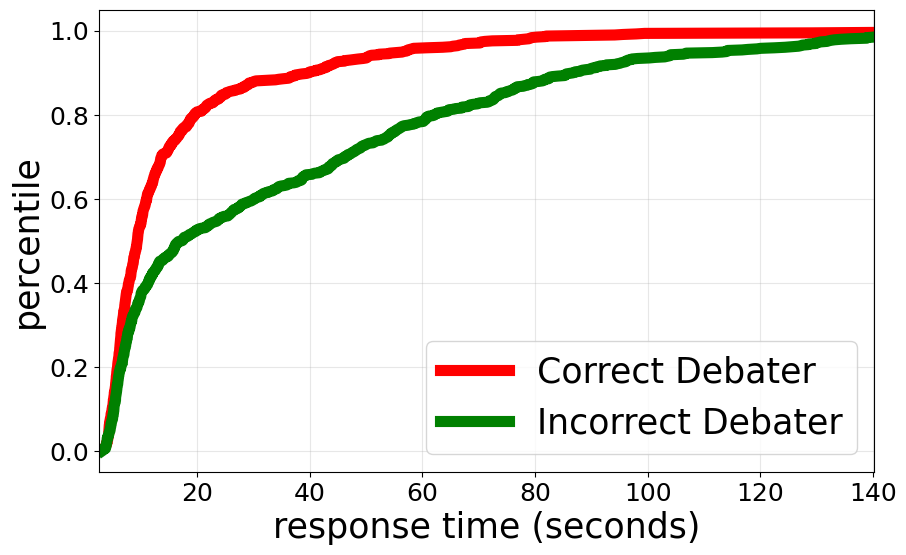

In [14]:
ax = cdf((correct_debater_response_times, incorrect_debater_response_times), labels=['Correct Debater', 'Incorrect Debater'], xlim_percentiles=[0, 99])
plt.xlabel('response time (seconds)', fontsize=25)
plt.ylabel('percentile', fontsize=25)
plt.show()

Plot 4

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '..')
from analysis.analysis_utils import *

human_verdicts_file = '../results/human/human_verdicts.jsonl'
human_df = pd.read_json(human_verdicts_file, lines=True)

run_id = '0vayjit'
human_df = human_df[human_df['run_id'] == run_id]

debates_df = prepare_df(['debates'])
debates_df = debates_df[debates_df['run_id_debates'] == run_id]

merged = human_df.merge(debates_df[['run_id_debates', 'record_id_debates', 'correct_idx_debates']], 
                        left_on=['run_id', 'record_id'], 
                        right_on=['run_id_debates', 'record_id_debates'])

merged['verdict'] = merged['verdict'].astype(int)
merged['correct_idx_debates'] = merged['correct_idx_debates'].astype(int)
merged['confidence'] = merged['confidence'].astype(float) / 100.0

merged['is_correct'] = merged['verdict'] == merged['correct_idx_debates']

/Users/joshlevy/projects/llm_judge_debate_NEW/analysis/../analysis/analysis_utils.py:102: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(aligned_dfs, ignore_index=True)


Accuracy: 0.889
Brier Score: 0.0711
Baseline Brier Score (always predict 0.5): 0.2500


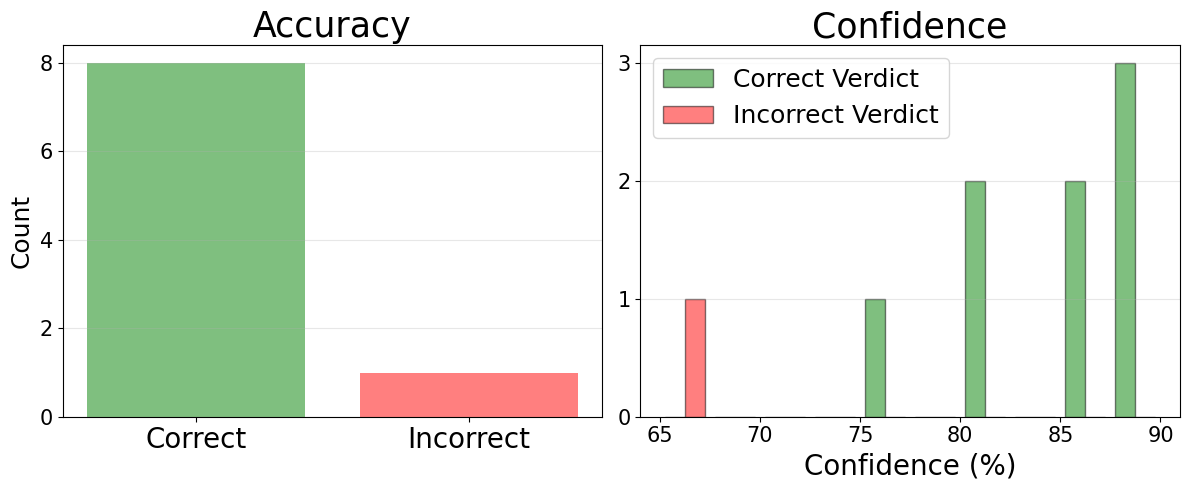


Brier Score: 0.0711
Baseline Brier Score: 0.2500
Improvement: 0.1789


In [16]:
def compute_brier_score(merged_df):
    brier_scores = []
    for _, row in merged_df.iterrows():
        verdict = row['verdict']
        confidence = row['confidence']
        correct = row['correct_idx_debates']
        
        if verdict == correct:
            predicted_prob_correct = confidence
        else:
            predicted_prob_correct = 1.0 - confidence
        
        actual = 1.0
        brier_score = (predicted_prob_correct - actual) ** 2
        brier_scores.append(brier_score)
    
    return np.mean(brier_scores)

accuracy = merged['is_correct'].mean()
print(f"Accuracy: {accuracy:.3f}")

brier_score = compute_brier_score(merged)
print(f"Brier Score: {brier_score:.4f}")

baseline_brier = 0.25
print(f"Baseline Brier Score (always predict 0.5): {baseline_brier:.4f}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.bar(['Correct', 'Incorrect'], [merged['is_correct'].sum(), (~merged['is_correct']).sum()], 
        color=['green', 'red'], alpha=0.5)
ax1.set_ylabel('Count', fontsize=18)
# ax1.set_title(f'Accuracy: {accuracy:.1%}', fontsize=14, fontweight='bold')
ax1.set_title(f'Accuracy',  fontsize=25)

ax1.grid(axis='y', alpha=0.3)
ax1.tick_params(axis='y', labelsize=15)
ax1.tick_params(axis='x', labelsize=20)


correct_conf = merged[merged['is_correct']]['confidence'] * 100
incorrect_conf = merged[~merged['is_correct']]['confidence'] * 100

ax2.hist([correct_conf, incorrect_conf], bins=10, alpha=0.5, 
         label=['Correct Verdict', 'Incorrect Verdict'], color=['green', 'red'], edgecolor='black')
ax2.set_xlabel('Confidence (%)', fontsize=20)
ax2.set_title('Confidence', fontsize=25)
ax2.legend(fontsize=18)
ax2.grid(axis='y', alpha=0.3)
ax2.tick_params(axis='both', labelsize=15)
ax2.yaxis.set_major_locator(plt.MaxNLocator(integer=True))

plt.tight_layout()
plt.show()

print(f"\nBrier Score: {brier_score:.4f}")
print(f"Baseline Brier Score: {baseline_brier:.4f}")
print(f"Improvement: {baseline_brier - brier_score:.4f}")

Comparison to LLM brier score

In [22]:
verdict_group_batch = "82ifg57"
verdict_ids, _ = get_verdict_ids_from_batch(verdict_group_batch)
verdicts_df = prepare_df(specific_verdict_ids=verdict_ids)
verdicts_df = verdicts_df[(verdicts_df['is_correct_qa_judge'].notnull()) & (verdicts_df['is_correct_verdict'].notnull()) & (verdicts_df['is_correct_qa_debater'].notnull())]

/Users/joshlevy/projects/llm_judge_debate_NEW/analysis/../analysis/analysis_utils.py:102: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(aligned_dfs, ignore_index=True)
/Users/joshlevy/projects/llm_judge_debate_NEW/analysis/../analysis/analysis_utils.py:102: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(aligned_dfs, ignore_index=True)


In [23]:
temp_df = verdicts_df[verdicts_df['parsed_confidence_verdicts'].notnull()].copy()
print(f"Total rows: {len(temp_df)}")
print(f"Null confidence: {temp_df['parsed_confidence_verdicts'].isnull().sum()}")

def compute_brier_score(df):
    brier_scores = []
    for _, row in df.iterrows():
        confidence = row['parsed_confidence_verdicts'] / 100.0
        is_correct = row['is_correct_verdict']
        
        if is_correct:
            predicted_prob_correct = confidence
        else:
            predicted_prob_correct = 1.0 - confidence
        
        actual = 1.0
        brier_score = (predicted_prob_correct - actual) ** 2
        brier_scores.append(brier_score)
    
    return np.mean(brier_scores)

brier_score = compute_brier_score(temp_df)
baseline_brier = 0.25

print(f"Brier Score: {brier_score:.4f}")
print(f"Baseline Brier Score: {baseline_brier:.4f}")
print(f"Improvement: {baseline_brier - brier_score:.4f}")


Total rows: 2310
Null confidence: 0
Brier Score: 0.2164
Baseline Brier Score: 0.2500
Improvement: 0.0336


In [25]:
(0.2164 - 0.0711) / .2164

0.6714417744916821

Plot 5

In [26]:
verdict_group_batch = "6irkzm1"
verdict_ids, data = get_verdict_ids_from_batch(verdict_group_batch)
verdicts_df = prepare_df(specific_verdict_ids=verdict_ids)
verdicts_df = verdicts_df[(verdicts_df['is_correct_qa_judge'].notnull()) & (verdicts_df['is_correct_verdict'].notnull()) & (verdicts_df['is_correct_qa_debater'].notnull())]

/Users/joshlevy/projects/llm_judge_debate_NEW/analysis/../analysis/analysis_utils.py:102: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(aligned_dfs, ignore_index=True)


In [27]:
verdicts_df = verdicts_df[(verdicts_df['config_model_name_qa_judge'] != 'meta-llama/llama-4-scout') & (verdicts_df['config_model_name_qa_debater'] != 'meta-llama/llama-4-scout')]
verdicts_df = verdicts_df[(verdicts_df['config_model_name_qa_judge'] != 'meta-llama/llama-3.1-405b-instruct') & (verdicts_df['config_model_name_qa_debater'] != 'meta-llama/llama-3.1-405b-instruct')]

In [28]:
verdicts_df['config_model_name_qa_debater'].value_counts()

config_model_name_qa_debater
meta-llama/llama-3.3-70b-instruct    2101
openai/gpt-4o-mini                   2099
google/gemma-3-12b-it                2088
meta-llama/llama-3.1-70b-instruct    2082
openai/gpt-3.5-turbo                 2077
qwen/qwen-2.5-72b-instruct           2061
x-ai/grok-4-fast                     2052
meta-llama/llama-3-8b-instruct       2036
meta-llama/llama-4-maverick          2035
meta-llama/llama-3.1-8b-instruct     1995
google/gemma-3-27b-it                1628
Name: count, dtype: int64

In [29]:
aggregate_acc = aggregate_by_fields(verdicts_df, fields=['verdict_run_id_verdicts'])
aggregate_acc = aggregate_acc.merge(verdicts_df[['verdict_run_id_verdicts', 'config_judge_model_verdicts', 'config_debater_model_debates']].drop_duplicates(), left_on='name', right_on='verdict_run_id_verdicts', how='inner')
# aggregate_acc = aggregate_acc[aggregate_acc['n_total'] > 180] # this is a little fairer and improves the results a bit because weak models tend to have more nones, and that probably means they tend to answer more easy questions where debate is less likely to benefit. but it's a bit arbitrary so we don't need to do it.

/Users/joshlevy/projects/llm_judge_debate_NEW/analysis/../analysis/analysis_utils.py:209: RuntimeWarning: divide by zero encountered in scalar divide
  'pgr': (df['is_correct_verdict'].mean() - df['is_correct_qa_judge'].mean()) / (df['is_correct_qa_debater'].mean() - df['is_correct_qa_judge'].mean()),


In [30]:
aggregate_acc.shape

(121, 18)

In [31]:
verdict_avg = aggregate_acc.groupby('config_debater_model_debates')['verdict_acc'].mean()
qa_avg = aggregate_acc.groupby('config_debater_model_debates')['judge_qa_acc'].mean().mean()

temp = aggregate_acc[~aggregate_acc['config_judge_model_verdicts'].isin(['x-ai/grok-4-fast', 'meta-llama/llama-4-maverick'])]
verdict_avg_minus2 = temp.groupby('config_debater_model_debates')['verdict_acc'].mean()
qa_avg_minus2 = temp.groupby('config_debater_model_debates')['judge_qa_acc'].mean().mean()

print(verdict_avg, qa_avg)
print(verdict_avg_minus2, qa_avg_minus2)

config_debater_model_debates
google/gemma-3-12b-it                0.584744
google/gemma-3-27b-it                0.646737
meta-llama/llama-3-8b-instruct       0.617302
meta-llama/llama-3.1-70b-instruct    0.609251
meta-llama/llama-3.1-8b-instruct     0.634036
meta-llama/llama-3.3-70b-instruct    0.619556
meta-llama/llama-4-maverick          0.704813
openai/gpt-3.5-turbo                 0.608436
openai/gpt-4o-mini                   0.618571
qwen/qwen-2.5-72b-instruct           0.644094
x-ai/grok-4-fast                     0.703303
Name: verdict_acc, dtype: float64 0.651841336035787
config_debater_model_debates
google/gemma-3-12b-it                0.543209
google/gemma-3-27b-it                0.616942
meta-llama/llama-3-8b-instruct       0.566395
meta-llama/llama-3.1-70b-instruct    0.566634
meta-llama/llama-3.1-8b-instruct     0.585926
meta-llama/llama-3.3-70b-instruct    0.582397
meta-llama/llama-4-maverick          0.677808
openai/gpt-3.5-turbo                 0.554297
openai/gpt-4o-mi

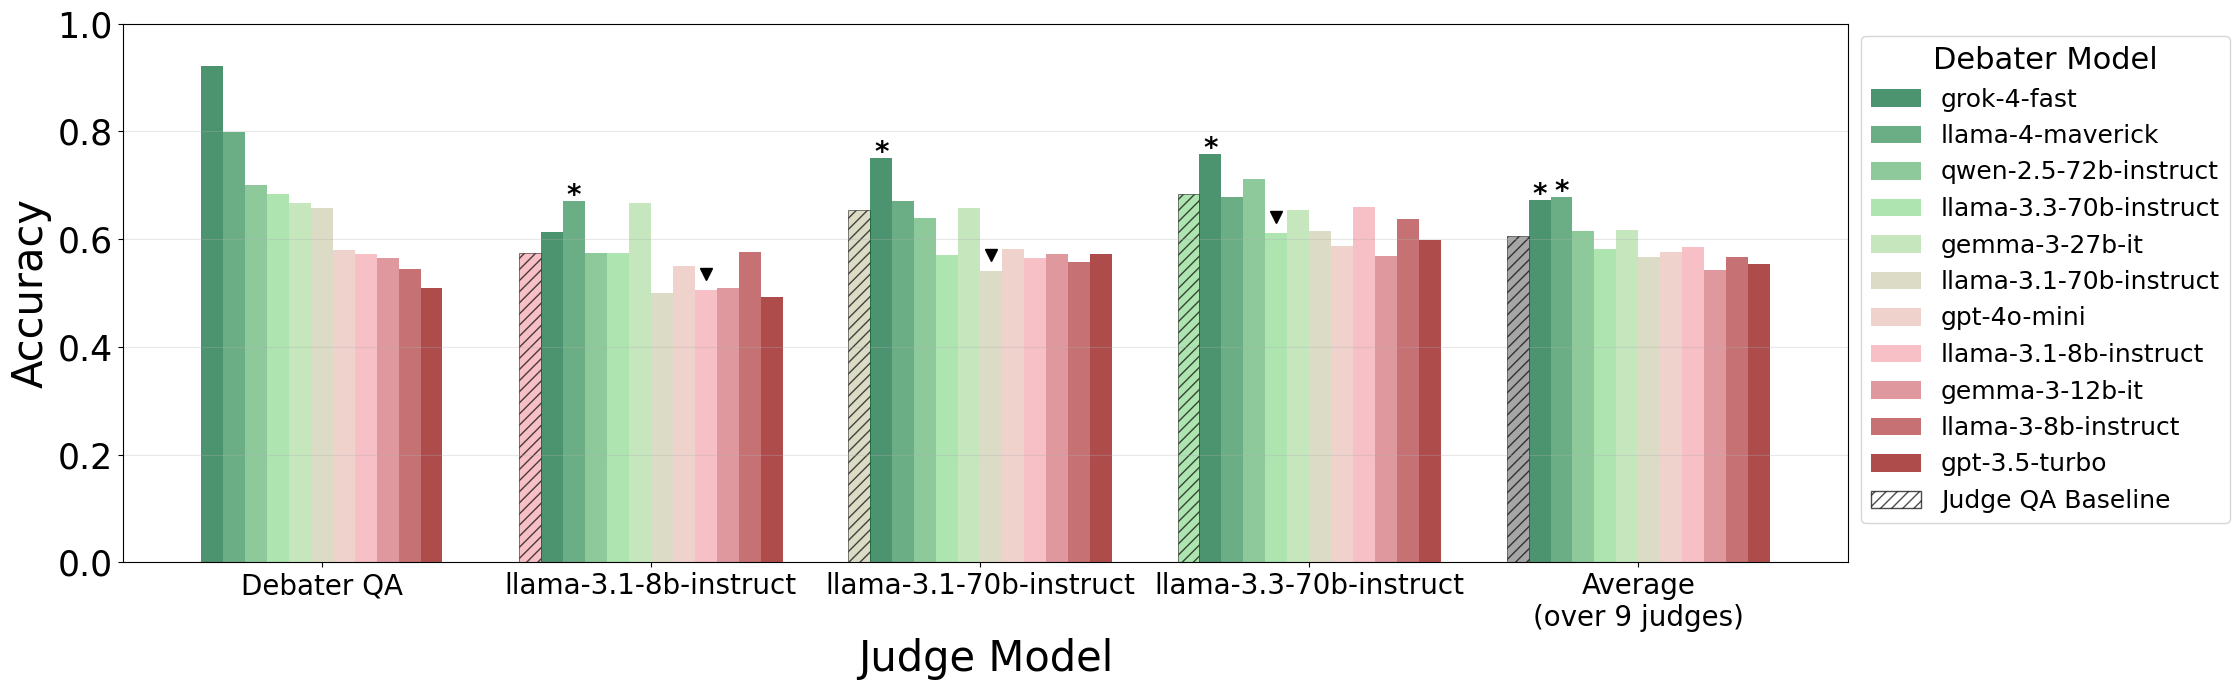

In [32]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
from statsmodels.stats.proportion import proportions_ztest

# ============================================================================
# Configuration
# ============================================================================
judge_models_to_show = ['meta-llama/llama-3.3-70b-instruct', 
                        'meta-llama/llama-3.1-70b-instruct', 
                        'meta-llama/llama-3.1-8b-instruct']

# ============================================================================
# Data Preparation
# ============================================================================
run_mapping = pd.DataFrame(data['runs'])
merged = aggregate_acc.merge(run_mapping, left_on='name', right_on='verdict_run_id')

# ============================================================================
# Significance Testing
# ============================================================================
def test_significance(verdict_correct, verdict_total, baseline_correct, baseline_total):
    count = np.array([verdict_correct, baseline_correct])
    nobs = np.array([verdict_total, baseline_total])
    z_stat, p_value = proportions_ztest(count, nobs, alternative='larger')
    return p_value < 0.05

# Test debater models vs overall judge QA
judge_qa_correct_total = aggregate_acc['judge_qa_n_correct'].sum()
judge_qa_total = aggregate_acc['n_judge_qa_not_null'].sum()

significant_debaters = {}
for debater_model in aggregate_acc['config_debater_model_debates'].unique():
    rows = aggregate_acc[aggregate_acc['config_debater_model_debates'] == debater_model]
    significant_debaters[debater_model] = test_significance(
        rows['verdict_n_correct'].sum(), rows['n_verdict_not_null'].sum(),
        judge_qa_correct_total, judge_qa_total
    )

# Test each judge-debater pair
significant_judge_debater_pairs = {}
# print("Significant judge-debater pairs:")
for judge_model in aggregate_acc['config_judge_model_verdicts'].unique():
    for debater_model in aggregate_acc['config_debater_model_debates'].unique():
        pair_rows = aggregate_acc[
            (aggregate_acc['config_judge_model_verdicts'] == judge_model) &
            (aggregate_acc['config_debater_model_debates'] == debater_model)
        ]
        
        if len(pair_rows) > 0:
            judge_qa_correct = pair_rows['judge_qa_n_correct'].sum()
            judge_qa_total = pair_rows['n_judge_qa_not_null'].sum()
            verdict_correct = pair_rows['verdict_n_correct'].sum()
            verdict_total = pair_rows['n_verdict_not_null'].sum()
            
            if judge_qa_total > 0 and verdict_total > 0:
                is_sig = test_significance(verdict_correct, verdict_total, judge_qa_correct, judge_qa_total)
                significant_judge_debater_pairs[(judge_model, debater_model)] = is_sig
                
                if is_sig:
                    j_short = judge_model.split('/')[-1]
                    d_short = debater_model.split('/')[-1]
                    v_acc = verdict_correct / verdict_total
                    j_acc = judge_qa_correct / judge_qa_total
                    # print(f"  {j_short} + {d_short}: {v_acc:.3f} vs {j_acc:.3f}")

# ============================================================================
# Helper Functions
# ============================================================================
def get_model_short_name(full_name):
    return full_name.split('/')[-1] if '/' in full_name else full_name

def calculate_bar_offset(bar_idx, n_bars, bar_width):
    return (bar_idx - n_bars / 2 + 0.5) * bar_width

def add_significance_star(ax, x, y, fontsize=20):
    ax.text(x, y + 0.01, '*', ha='center', va='center', fontsize=fontsize, fontweight='bold')

# ============================================================================
# Build Labels and Colors
# ============================================================================
debate_run_id_labels = {}
for debate_run_id in merged['debate_run_id'].unique():
    with open(f"../results/debates/{debate_run_id}.jsonl", "r") as f:
        debate_record = json.loads(f.readline())
    debater_model = debate_record['config']['debater_model']
    debate_run_id_labels[debate_run_id] = get_model_short_name(debater_model)

colors_list = [
    (0.0, (0.0, 0.4, 0.2)), (0.33, (0.6, 0.9, 0.6)),
    (0.67, (1.0, 0.71, 0.76)), (1.0, (0.55, 0.0, 0.0))
]
custom_cmap = mcolors.LinearSegmentedColormap.from_list('green_yellow_red', colors_list)

# ============================================================================
# Prepare Plot Data
# ============================================================================
plot_data = merged[merged['run_idx'] == 0].copy()

# Sort debate runs by QA accuracy
debater_scores = plot_data.groupby('debate_run_id')['debater_qa_acc'].first().sort_values(ascending=False)
debate_run_ids = debater_scores.index.tolist()

# Map judge models to their matching debater (for coloring)
judge_to_debate_run = {}
for judge_model in plot_data['model'].unique():
    for debate_idx, debate_run_id in enumerate(debate_run_ids):
        debate_row = plot_data[plot_data['debate_run_id'] == debate_run_id].iloc[0]
        debater_short = debate_run_id_labels[debate_run_id]
        judge_short = get_model_short_name(judge_model)
        if debater_short == judge_short:
            judge_to_debate_run[judge_model] = debate_idx
            break

# Filter and sort judge models
judge_models = sorted(plot_data['model'].unique(), 
                     key=lambda x: judge_to_debate_run.get(x, -1), 
                     reverse=True)
if judge_models_to_show:
    judge_models = [jm for jm in judge_models if jm in judge_models_to_show]

# ============================================================================
# Setup Plot
# ============================================================================
n_judges = len(judge_models)
n_debates = len(debate_run_ids)
group_width = 0.8
bar_width = group_width / (n_debates + 1)

fig, ax = plt.subplots(figsize=(25, 7))
colors = custom_cmap(np.linspace(0.0, 1.0, n_debates))
    
x_labels = ['Debater QA'] + judge_models
x_positions = np.arange(len(x_labels))

# ============================================================================
# Plot: Debater QA Baseline (leftmost group)
# ============================================================================
for i, debate_run_id in enumerate(debate_run_ids):
    row = plot_data[plot_data['debate_run_id'] == debate_run_id].iloc[0]
    offset = calculate_bar_offset(i, n_debates, bar_width)
    ax.bar(offset, row['debater_qa_acc'], bar_width, color=colors[i], alpha=0.7)
    
# ============================================================================
# Plot: Judge Model Groups (QA baseline + verdicts for each debater)
# ============================================================================
for judge_idx, judge_model in enumerate(judge_models):
    x_pos = judge_idx + 1
    judge_color_idx = judge_to_debate_run.get(judge_model, 0)
    
    # Judge QA baseline bar (hatched, colored by matching debater)
    judge_row = plot_data[plot_data['model'] == judge_model].iloc[0]
    qa_offset = calculate_bar_offset(0, n_debates + 1, bar_width)
    ax.bar(x_pos + qa_offset, judge_row['judge_qa_acc'], bar_width, 
           color=colors[judge_color_idx], alpha=0.7, hatch='///', 
           edgecolor='black', linewidth=0.5)
    
    # Arrow marker above matching debater verdict
    verdict_offset = calculate_bar_offset(judge_color_idx + 1, n_debates + 1, bar_width)
    matching_row = plot_data[(plot_data['model'] == judge_model) & 
                            (plot_data['debate_run_id'] == debate_run_ids[judge_color_idx])]
    if len(matching_row) > 0:
        verdict_acc = matching_row['verdict_acc'].values[0]
        ax.plot(x_pos + verdict_offset, verdict_acc + 0.03, marker='v', 
               color='black', markersize=8)
    
    # Verdict bars for each debater
    for i, debate_run_id in enumerate(debate_run_ids):
        verdict_row = plot_data[(plot_data['model'] == judge_model) & 
                               (plot_data['debate_run_id'] == debate_run_id)]
        if len(verdict_row) > 0:
            verdict_acc = verdict_row['verdict_acc'].values[0]
            debater_model = verdict_row['config_debater_model_debates'].values[0]
            offset = calculate_bar_offset(i + 1, n_debates + 1, bar_width)
            
            ax.bar(x_pos + offset, verdict_acc, bar_width, color=colors[i], alpha=0.7)
            
            if significant_judge_debater_pairs.get((judge_model, debater_model), False):
                add_significance_star(ax, x_pos + offset, verdict_acc)
    
# ============================================================================
# Plot: Average Group (rightmost)
# ============================================================================
x_pos = len(judge_models) + 1
x_labels.append('Average\n(over 9 judges)')

# Average QA baseline (gray, hatched)
qa_offset = calculate_bar_offset(0, n_debates + 1, bar_width)
ax.bar(x_pos + qa_offset, qa_avg_minus2, bar_width, color='gray', alpha=0.7, 
       hatch='///', edgecolor='black', linewidth=0.5)

# Average verdicts for each debater
for i, debate_run_id in enumerate(debate_run_ids):
    debater_model = plot_data[plot_data['debate_run_id'] == debate_run_id].iloc[0]['config_debater_model_debates']
    verdict_val = verdict_avg_minus2[debater_model]
    offset = calculate_bar_offset(i + 1, n_debates + 1, bar_width)
    
    ax.bar(x_pos + offset, verdict_val, bar_width, color=colors[i], alpha=0.7)
    
    if significant_debaters.get(debater_model, False):
        add_significance_star(ax, x_pos + offset, verdict_val)

# ============================================================================
# Format Plot
# ============================================================================
from matplotlib.patches import Patch

x_positions = np.arange(len(x_labels))
ax.set_xlabel('Judge Model', fontsize=30)
ax.set_ylabel('Accuracy', fontsize=30)
ax.set_xticks(x_positions)
ax.set_xticklabels([get_model_short_name(label) for label in x_labels], 
                   rotation=0, fontsize=20)
ax.tick_params(axis='y', labelsize=25)

# Legend
legend_elements = [Patch(facecolor=colors[i], alpha=0.7, 
                         label=debate_run_id_labels[debate_run_ids[i]]) 
                  for i in range(n_debates)]
legend_elements.append(Patch(facecolor='white', alpha=0.7, hatch='///', 
                            edgecolor='black', label='Judge QA Baseline'))

ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1])
ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1), 
         title='Debater Model', fontsize=18, title_fontsize=22)

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

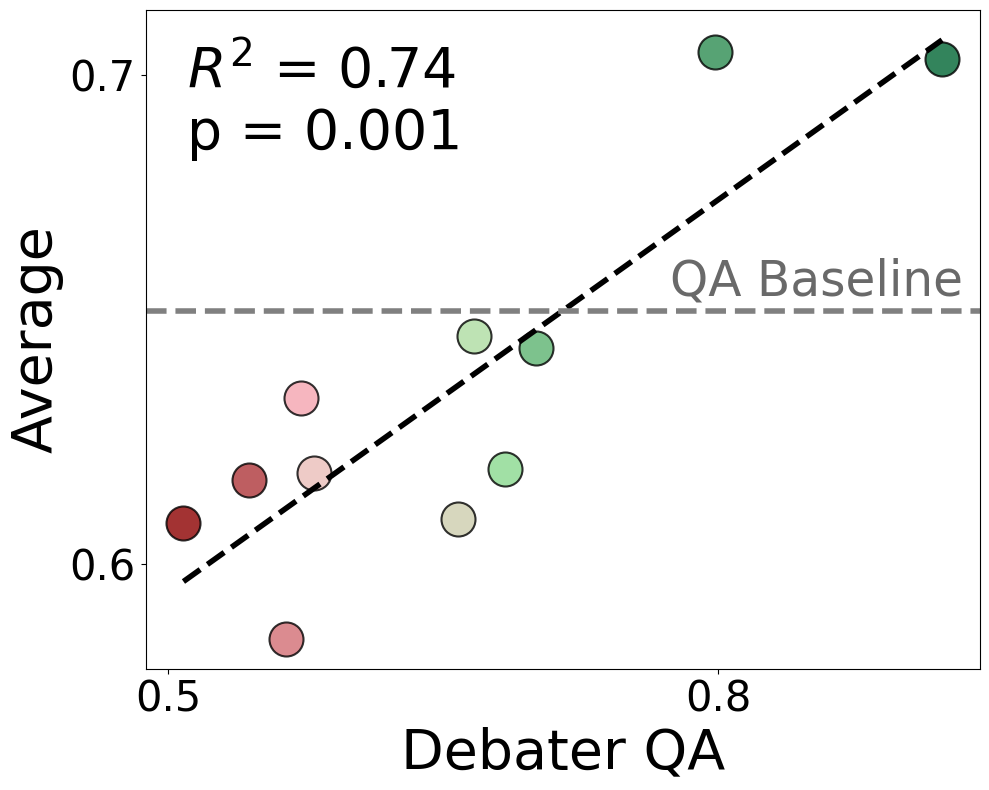

Linear Regression:
  Slope: 0.2678
  Intercept: 0.4603
  R-squared: 0.7394
  P-value: 6.8753e-04
  Std Error: 0.0530


In [33]:
from scipy import stats

fig, ax = plt.subplots(figsize=(10, 8))

debater_data = plot_data.groupby('config_debater_model_debates').agg({
    'debater_qa_acc': 'first',
    'verdict_acc': 'mean'
}).reset_index()
debater_data = debater_data.sort_values('debater_qa_acc', ascending=False)

avg_judge_qa = plot_data['judge_qa_acc'].mean()

colors = custom_cmap(np.linspace(0.0, 1.0, len(debater_data)))

for i, (_, row) in enumerate(debater_data.iterrows()):
    ax.scatter(row['debater_qa_acc'], row['verdict_acc'], s=600, alpha=0.8, color=colors[i], edgecolors='black', linewidth=1.5)

slope, intercept, r_value, p_value, std_err = stats.linregress(debater_data['debater_qa_acc'], debater_data['verdict_acc'])
x_fit = np.linspace(debater_data['debater_qa_acc'].min(), debater_data['debater_qa_acc'].max(), 100)
y_fit = slope * x_fit + intercept
ax.plot(x_fit, y_fit, 'k--', linewidth=4)

ax.axhline(avg_judge_qa, color='gray', linestyle='--', linewidth=4)

ax.set_xlabel('Debater QA', fontsize=40)
ax.set_ylabel('Average', fontsize=40)
ax.tick_params(axis='both', labelsize=30)
ax.set_xticks([0.5, 0.80])
ax.locator_params(axis='y', nbins=2)

ax.text(ax.get_xlim()[1] * 0.99, avg_judge_qa + 0.001, 'QA Baseline', 
        fontsize=35, ha='right', va='bottom', color='dimgray')

ax.text(0.05, 0.95, f'$R^2$ = {r_value**2:.2f}\np = {p_value:.3f}', 
        transform=ax.transAxes, fontsize=40, va='top')

plt.tight_layout()
plt.show()

print(f"Linear Regression:")
print(f"  Slope: {slope:.4f}")
print(f"  Intercept: {intercept:.4f}")
print(f"  R-squared: {r_value**2:.4f}")
print(f"  P-value: {p_value:.4e}")
print(f"  Std Error: {std_err:.4f}")
